# Conditional Counterfactual Density Estimation Demo

This notebook demonstrates the use of **Conditional Counterfactual Mean Embedding (CCME)** for estimating conditional distributions of counterfactual outcomes.

## Overview

We'll use the **IHDP (Infant Health and Development Program)** dataset to:
1. Estimate conditional counterfactual densities $p(Y^1 | V)$
2. Compare different estimators (ridge, df, nk)
3. Evaluate Doubly Robust (dr) vs One-Step (onestep) methods
4. Visualize conditional counterfactual densities

## Setup and Imports

In [ ]:
!git clone -q https://github.com/donlap/Conditional-Counterfactual-Mean-Embeddings
!pip install -q equinox hydra-core

import sys
sys.path.append('/content/Conditional-Counterfactual-Mean-Embeddings')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from omegaconf import OmegaConf
import ipywidgets as widgets
from IPython.display import display, clear_output

from ccme import CCDEstimator

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Imports successful!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.5 MB/s eta 0:00:00
Imports successful!


## Load IHDP Dataset

The IHDP dataset contains data from a randomized experiment evaluating the effect of intensive childcare on cognitive test scores.

- **Treatment (A)**: Participation in intensive childcare program (0 or 1)
- **Outcome (Y)**: Cognitive test score (continuous)
- **Covariates (X)**: Mother's age, education, birth weight, etc.

In [ ]:
def load_ihdp_data():
    url = "https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv"
    df = pd.read_csv(url, header=None)

    col_names = ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [f"x{i}" for i in range(1, 26)]
    df.columns = col_names

    X = df.loc[:, "x1":"x25"].values

    A = df["treatment"].values.astype(int)

    Y = df["y_factual"].values[:, None]

    Y0_true = df["mu0"].values
    Y1_true = df["mu1"].values

    return X, Y, A, Y0_true, Y1_true


X, Y, A, Y0_true, Y1_true = load_ihdp_data()
n_samples = len(Y)

print(f"Dataset loaded: {n_samples} samples")
print(f"  - Treated: {A.sum()} ({A.mean()*100:.1f}%)")
print(f"  - Control: {(1-A).sum()} ({(1-A.mean())*100:.1f}%)")
print(f"  - Covariates: {X.shape[1]} dimensions")
print(f"  - Outcome range: [{Y.min():.1f}, {Y.max():.1f}]")

Dataset loaded: 747 samples
  - Treated: 139 (18.6%)
  - Control: 608 (81.4%)
  - Covariates: 25 dimensions
  - Outcome range: [-1.5, 11.3]


## Data Exploration

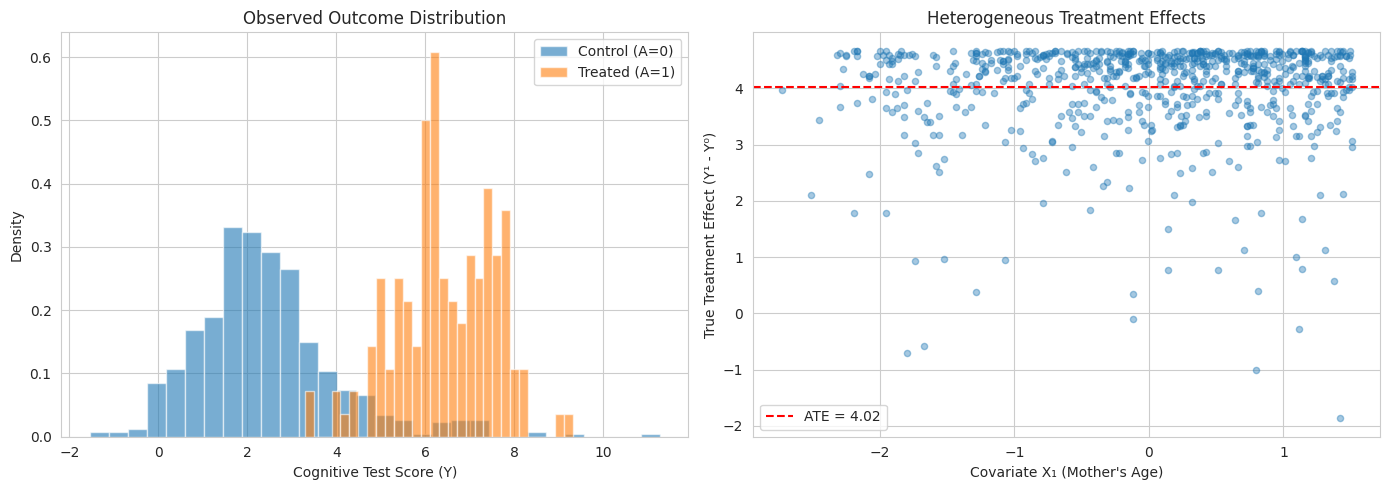


Average Treatment Effect (ATE): 4.02
Treatment Effect Range: [-1.87, 4.67]


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Outcome distribution by treatment
axes[0].hist(Y[A==0], bins=30, alpha=0.6, label='Control (A=0)', density=True)
axes[0].hist(Y[A==1], bins=30, alpha=0.6, label='Treated (A=1)', density=True)
axes[0].set_xlabel('Cognitive Test Score (Y)')
axes[0].set_ylabel('Density')
axes[0].set_title('Observed Outcome Distribution')
axes[0].legend()

# Plot 2: True treatment effects (heterogeneity)
true_te = Y1_true - Y0_true
axes[1].scatter(X[:, 0], true_te, alpha=0.4, s=20)
axes[1].axhline(y=true_te.mean(), color='r', linestyle='--', label=f'ATE = {true_te.mean():.2f}')
axes[1].set_xlabel('Covariate X₁ (Mother\'s Age)')
axes[1].set_ylabel('True Treatment Effect (Y¹ - Y⁰)')
axes[1].set_title('Heterogeneous Treatment Effects')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nAverage Treatment Effect (ATE): {true_te.mean():.2f}")
print(f"Treatment Effect Range: [{true_te.min():.2f}, {true_te.max():.2f}]")

## Interactive Configuration

Use the form below to configure the estimator. You can adjust:
- **Method**: ridge (kernel), df (deep features), or nk (neural-kernel)
- **Mode**: dr (doubly robust), onestep, ipw, or pi (plug-in)
- **Hyperparameters**: Model architecture and training settings

In [ ]:
# @title Configuration Form
# @markdown ### Method & Mode

method = "df" # @param ["ridge", "df", "nk"]
mode = "dr" # @param ["dr", "onestep", "ipw", "pi"]

# @markdown ### Model Hyperparameters
output_dim = 20 # @param {type:"slider", min:5, max:100, step:5}
hidden_dim_str = "[20, 20]" # @param {type:"string"}
sigma = 1 # @param {type:"slider", min:0.1, max:10.0, step:0.1}
reg_lambda = 1.0 # @param {type:"number"}

# @markdown ### Training Parameters
lr_or = 2e-2 # @param {type:"number"}
lr_fi = 2e-2 # @param {type:"number"}
epoch_or = 3000 # @param {type:"slider", min:100, max:10000, step:100}
epoch_fi = 500 # @param {type:"slider", min:100, max:5000, step:100}
batch_size = 512 # @param {type:"slider", min:32, max:512, step:32}

# @markdown ### Validation & Early Stopping
valid_size = 0.2 # @param {type:"slider", min:0.0, max:0.5, step:0.05}
patience = 50 # @param {type:"slider", min:0, max:200, step:10}

# @markdown ### Other Settings
seed = 42 # @param {type:"integer"}
verbose = True # @param {type:"boolean"}
n_folds = 3 # @param {type:"integer"}

# --- Post-processing (Parsing the string input back to list) ---
import ast
try:
    hidden_dim = ast.literal_eval(hidden_dim_str)
except:
    print("Error parsing hidden_dim. Defaulting to [20, 20]")
    hidden_dim = [20, 20]

print(" Configuration Loaded!")
print(f" Method: {method}, Mode: {mode}")
print(f" Hidden Layers: {hidden_dim}")

 Configuration Loaded!
 Method: df, Mode: dr
 Hidden Layers: [20, 20]


## Build Configuration and Train Model

In [ ]:
def build_config():
    """Build OmegaConf configuration from global form variables"""

    try:
        current_hidden = eval(hidden_dim_str) if isinstance(hidden_dim_str, str) else hidden_dim
        if not isinstance(current_hidden, list):
            current_hidden = [current_hidden]
    except:
        current_hidden = [20, 20]
        print("Invalid hidden_dim format, using default [20, 20]")

    lamb_value = None if method == 'nk' else reg_lambda

    val_size_final = valid_size if valid_size > 0 else None
    patience_final = patience if patience > 0 else None

    n_folds_final = n_folds if n_folds >= 2 else None

    config_dict = {
        'method': method,
        'mode': mode,
        'seed': seed,
        'verbose': verbose,
        'n_folds': n_folds_final,
        'model': {
            'output_dim': output_dim,
            'hidden_dim': current_hidden,
            'sigma_init': sigma,
            'lamb': lamb_value,
            'learn_sigma': False
        },
        'propensity_score_model': {
            '_target_': 'sklearn.ensemble.RandomForestClassifier',
            'max_depth': 4
        },
        'train': {
            'lr_or': lr_or,
            'lr_fi': lr_fi,
            'batch_size_or': batch_size,
            'batch_size_fi': batch_size,
            'epoch_or': epoch_or,
            'epoch_fi': epoch_fi,
            'valid_size_or': val_size_final,
            'valid_size_fi': val_size_final,
            'patience_or': patience_final,
            'patience_fi': patience_final
        },
        'test': {
            'num_bin': 1000
        }
    }

    return OmegaConf.create(config_dict)

cfg = build_config()

print("\nConfiguration built successfully!")
print(f"\nMethod: {cfg.method} | Mode: {cfg.mode}")
print(f"Model: {cfg.model.output_dim} atoms/features, σ={cfg.model.sigma_init}, λ={cfg.model.lamb}")
print(f"Training: {cfg.train.epoch_or} epochs (stage 1), {cfg.train.epoch_fi} epochs (stage 2)")
if cfg.train.valid_size_or:
    print(f"Validation: {cfg.train.valid_size_or*100:.0f}% with patience={cfg.train.patience_or}")
if cfg.n_folds:
    print(f"Cross-fitting: {cfg.n_folds} folds")


Configuration built successfully!

Method: df | Mode: dr
Model: 20 atoms/features, σ=1, λ=1.0
Training: 3000 epochs (stage 1), 500 epochs (stage 2)
Validation: 20% with patience=50
Cross-fitting: 3 folds


In [ ]:
# Train the model
print("\n" + "="*60)
print("TRAINING CCD ESTIMATOR")
print("="*60 + "\n")

# Use first 5 covariates for conditioning
V = X[:, :5]

# Initialize and fit
estimator = CCDEstimator(cfg)
estimator.fit(X=X, V=V, Y=Y, A=A)

print("\n" + "="*60)
print("TRAINING COMPLETED")
print("="*60)


TRAINING CCD ESTIMATOR



Fold 1/3 Stage 1: |██████████| 3000/3000 [00:56<00:00], train_loss=-0.98628, val_loss=-0.73561, patience=0000/0050
Fold 1/3 Stage 2: |████▎     | 213/500 [00:15<00:21], train_loss=-2.82982, val_loss=-1.13353, patience=0049/0050


Fold 1/3 Stage 2: Early stopping at epoch 215, restoring best model (val_loss=-1.16494)


Fold 2/3 Stage 1: |█████▎    | 1607/3000 [00:31<00:26], train_loss=-0.97147, val_loss=-0.67793, patience=0049/0050


Fold 2/3 Stage 1: Early stopping at epoch 1608, restoring best model (val_loss=-0.67809)


Fold 2/3 Stage 2: |█████▏    | 257/500 [00:14<00:14], train_loss=-3.45146, val_loss=-1.34067, patience=0049/0050


Fold 2/3 Stage 2: Early stopping at epoch 258, restoring best model (val_loss=-1.42898)


Fold 3/3 Stage 1: |█████████▌| 2881/3000 [00:52<00:02], train_loss=-0.98146, val_loss=-0.64580, patience=0049/0050


Fold 3/3 Stage 1: Early stopping at epoch 2882, restoring best model (val_loss=-0.64612)


Fold 3/3 Stage 2: |██████████| 500/500 [00:25<00:00], train_loss=-2.97209, val_loss=-0.83803, patience=0003/0050


TRAINING COMPLETED


## Visualize Estimated Densities

We'll visualize the estimated conditional counterfactual densities for different covariate profiles.

Estimating Densities... (Batch size: Full)


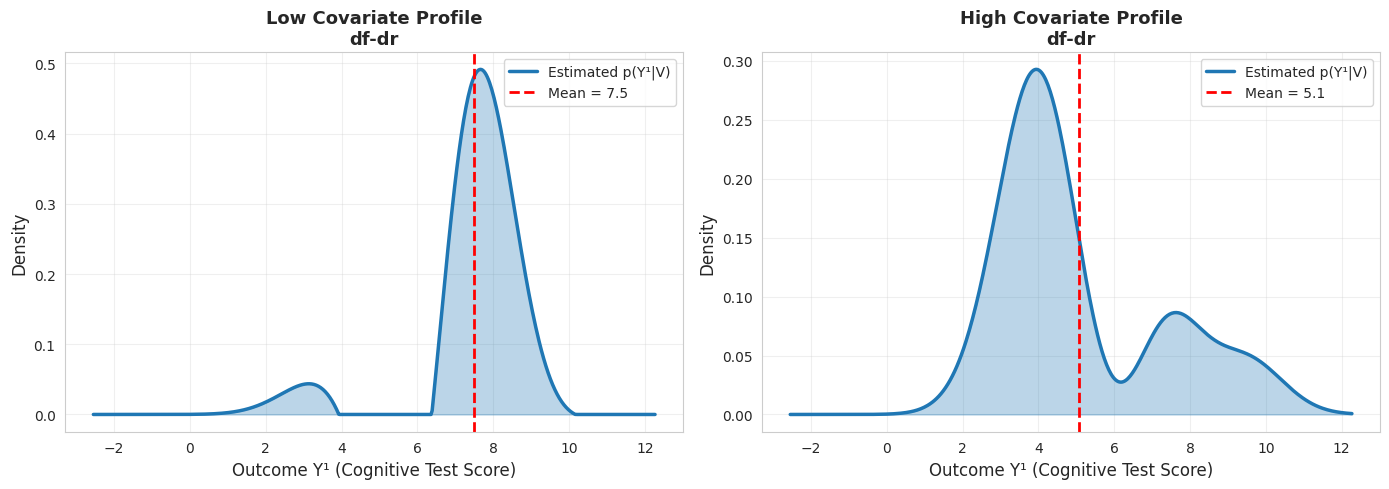


Estimated Conditional Means:
  Low profile: E[Y¹|V] = 7.50
  High profile: E[Y¹|V] = 5.07


In [ ]:
# Two distinct profiles based on standard IHDP feature meanings
# Feature 0 (x1): Birth Weight (Standardized)
# Feature 1 (x2): Head Circumference (Standardized)
# Feature 2 (x3): Weeks Preterm (Standardized)
# Feature 3 (x4): Birth Order (Standardized)

V_test = np.array([
    [-2.0, -2.0, -2.0, 0.0, 0.0],  # Profile 1: Low Weight, Small Head, Preterm
    [ 1.5,  1.5,  1.0, 0.0, 0.0]   # Profile 2: Heavy, Large Head, Full Term
])

# Define grid for density estimation
y_min, y_max = Y.min() - 1.0, Y.max() + 1.0
Y_grid = np.linspace(y_min, y_max, 500)[:, None]

# Predict densities
pdf_est = estimator.predict(V_eval=V_test, Y_grid=Y_grid)

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, (ax, profile_name) in enumerate(zip(axes, ['Low Covariate Profile', 'High Covariate Profile'])):
    ax.plot(Y_grid, pdf_est[i], linewidth=2.5, label=f'Estimated p(Y¹|V)', color='C0')
    ax.fill_between(Y_grid.flatten(), 0, pdf_est[i], alpha=0.3, color='C0')

    # Add vertical lines for mean and quantiles
    mean_est = np.sum(Y_grid.flatten() * pdf_est[i]) * (Y_grid[1] - Y_grid[0]).item()
    ax.axvline(mean_est, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_est:.1f}')

    ax.set_xlabel('Outcome Y¹ (Cognitive Test Score)', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title(f'{profile_name}\n{cfg.method}-{cfg.mode}', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nEstimated Conditional Means:")
for i, profile in enumerate(['Low', 'High']):
    mean_est = np.sum(Y_grid.flatten() * pdf_est[i]) * (Y_grid[1] - Y_grid[0]).item()
    print(f"  {profile} profile: E[Y¹|V] = {mean_est:.2f}")

## Distributional Insights Beyond Means

Extract richer information from the estimated densities:

In [ ]:
def compute_distributional_stats(y_grid, pdf):
    """Compute mean, variance, quantiles from density"""
    dy = y_grid[1] - y_grid[0]

    # Mean
    mean = np.sum(y_grid * pdf) * dy

    # Variance
    variance = np.sum((y_grid - mean)**2 * pdf) * dy
    std = np.sqrt(variance)

    # Quantiles
    cdf = np.cumsum(pdf) * dy
    q25 = y_grid[np.argmin(np.abs(cdf - 0.25))]
    q50 = y_grid[np.argmin(np.abs(cdf - 0.50))]
    q75 = y_grid[np.argmin(np.abs(cdf - 0.75))]

    return {
        'mean': mean,
        'std': std,
        'q25': q25,
        'q50': q50,
        'q75': q75
    }

# Compute stats for both profiles
y_grid_flat = Y_grid.flatten()

stats_low = compute_distributional_stats(y_grid_flat, pdf_est[0])
stats_high = compute_distributional_stats(y_grid_flat, pdf_est[1])

# Display results
results_df = pd.DataFrame({
    'Low Profile': [f"{stats_low['mean']:.2f}", f"{stats_low['std']:.2f}",
                    f"{stats_low['q25']:.2f}", f"{stats_low['q50']:.2f}", f"{stats_low['q75']:.2f}"],
    'High Profile': [f"{stats_high['mean']:.2f}", f"{stats_high['std']:.2f}",
                     f"{stats_high['q25']:.2f}", f"{stats_high['q50']:.2f}", f"{stats_high['q75']:.2f}"]
}, index=['Mean', 'Std Dev', '25th Percentile', 'Median', '75th Percentile'])

print("\nDISTRIBUTIONAL STATISTICS")
print("="*60)
print(results_df)
print("="*60)

# Interpretation
mean_diff = stats_high['mean'] - stats_low['mean']
print(f"\nINSIGHTS:")
print(f"  • Conditional Average Treatment Effect difference: {mean_diff:.2f}")
print(f"  • High profile has {'higher' if mean_diff > 0 else 'lower'} expected outcomes")
print(f"  • Low profile uncertainty (std): {stats_low['std']:.2f}")
print(f"  • High profile uncertainty (std): {stats_high['std']:.2f}")
print(f"  • IQR (Low): {stats_low['q75'] - stats_low['q25']:.2f}")
print(f"  • IQR (High): {stats_high['q75'] - stats_high['q25']:.2f}")


DISTRIBUTIONAL STATISTICS
                Low Profile High Profile
Mean                   7.50         5.07
Std Dev                1.48         2.27
25th Percentile        7.19         3.45
Median                 7.73         4.34
75th Percentile        8.29         6.69

INSIGHTS:
  • Conditional Average Treatment Effect difference: -2.43
  • High profile has lower expected outcomes
  • Low profile uncertainty (std): 1.48
  • High profile uncertainty (std): 2.27
  • IQR (Low): 1.10
  • IQR (High): 3.24


## Compare Multiple Methods

Compare CME, DF, and NN estimators on the same profile:


Training multiple methods for comparison...

Training ridge...
Training df...
Training nk...

All methods trained!



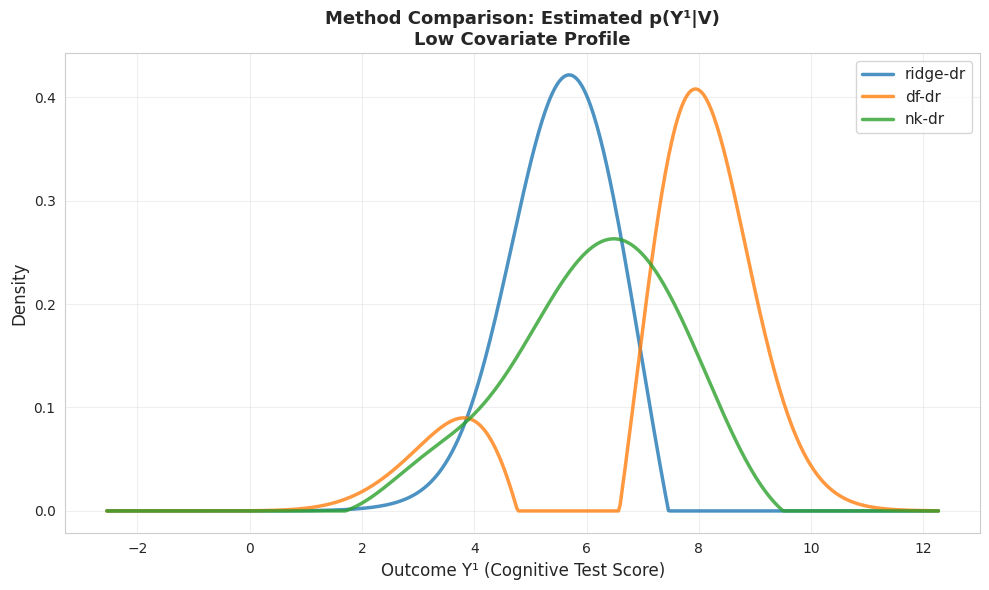


Estimated Means by Method:
  ridge: E[Y¹|V] = 5.50
  df: E[Y¹|V] = 7.38
  nk: E[Y¹|V] = 6.10


In [ ]:
# Train all three methods
methods = ['ridge', 'df', 'nk']
colors = ['C0', 'C1', 'C2']
estimators = {}
predictions = {}

print("\nTraining multiple methods for comparison...\n")

for method in methods:
    print(f"Training {method}...")

    # Update config
    cfg_temp = OmegaConf.create(OmegaConf.to_container(cfg))
    cfg_temp.method = method

    # Adjust hyperparameters by method
    if method == 'ridge':
        cfg_temp.model.lamb = 1.0
        cfg_temp.train.epoch_or = 1
        cfg_temp.train.epoch_fi = 1
    elif method == 'df':
        cfg_temp.model.lamb = 1.0
        cfg_temp.train.epoch_or = 3000
        cfg_temp.train.epoch_fi = 500
    else:  # nk
        cfg_temp.model.lamb = None
        cfg_temp.train.epoch_or = 10000
        cfg_temp.train.epoch_fi = 2000

    cfg_temp.verbose = False  # Suppress output

    # Train
    est = CCDEstimator(cfg_temp)
    est.fit(X=X, V=V, Y=Y, A=A)

    # Predict on first profile
    pred = est.predict(V_eval=V_test[:1], Y_grid=Y_grid)

    estimators[method] = est
    predictions[method] = pred[0]

print("\nAll methods trained!\n")

# Plot comparison
plt.figure(figsize=(10, 6))

for method, color in zip(methods, colors):
    plt.plot(Y_grid, predictions[method], linewidth=2.5, label=f'{method}-{cfg.mode}', color=color, alpha=0.8)

plt.xlabel('Outcome Y¹ (Cognitive Test Score)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title(f'Method Comparison: Estimated p(Y¹|V)\nLow Covariate Profile', fontsize=13, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nEstimated Means by Method:")
for method in methods:
    mean_est = np.sum(y_grid_flat * predictions[method]) * (Y_grid[1] - Y_grid[0]).item()
    print(f"  {method}: E[Y¹|V] = {mean_est:.2f}")